In [1]:
#
# Import Dataset
#
import os
from sklearn.datasets import load_files

DATA_SETS_PATH = 'data/data_sets'
DATA_SET_NAME = 'bbcsport'
CATEGORIES = ['athletics', 'cricket', 'football', 'rugby', 'tennis']

container_path = os.path.join(DATA_SETS_PATH, DATA_SET_NAME)
bunch = load_files(container_path=container_path, description=DATA_SET_NAME, categories=CATEGORIES, decode_error='ignore', encoding='utf-8')

In [1]:
#
# Helper Methods
#

import numpy as np

def get_dataset_info_string(dataset):
    """Ridiculous way to print out dataset info"""
    
    # count number of samples/documents in dataset
    num_docs = lambda i: list(zip(*np.unique(dataset.target, return_counts=True)))[i][1]
    
    # ordering of output
    display_column_order = ['Target', 'Target Name', 'Documents']
    
    # uses target as index
    column_param_funcs = {
        'Target' : lambda i: i,
        'Target Name' : lambda i: dataset.target_names[i],
        'Documents' : lambda i: num_docs(i)
    }
    
    column_names = list(column_param_funcs.keys())
    column_headers_dict = {column_name:column_name for column_name in column_names}
    column_values = zip(*[[v(i) for v in column_param_funcs.values()] for i in range(len(dataset.target_names))])

    # useful dictionaries 
    info_dict = [{k:v(i) for k,v in column_param_funcs.items()} for i in range(len(dataset.target_names))]
    merged_values_by_column = dict(zip(column_names, column_values))    
    
    # get maximum length string for each column name in dataset
    get_max_str_len = lambda list: max([len(str(i)) for i in list])
    max_header_len = {k: max(len(k),get_max_str_len(v)) for k,v in merged_values_by_column.items()}
    ordered_max_header_len = [(column_name, max_header_len[column_name]) for column_name in display_column_order] 
    
    # format output
    template = '|'.join(["{%s:%d}" % (column_name, max_len) for column_name, max_len in ordered_max_header_len])
    
    # create header
    header = template.format(**column_headers_dict)
    bar = '-'*(sum([o[1] for o in ordered_max_header_len]) + len(ordered_max_header_len))

    # add category info to display string
    description = dataset.DESCR
    if dataset.DESCR is None:
        description = "None"
    data_set_info_string = 'Dataset Description: \n' + dataset.DESCR + '\n' + bar + '\n' + header + '\n' + bar + '\n'
    for rec in info_dict: 
          data_set_info_string += template.format(**rec) + '\n'
    data_set_info_string += bar
    
    # add total number of documents to string
    total_documents = dataset.target.shape[0]
    data_set_info_string += "\nTotal Documents:\t" + str(total_documents)

            
    return data_set_info_string    

Dataset Description: 
bbcsport
-----------------------------
Target|Target Name|Documents
-----------------------------
     0|athletics  |      101
     1|cricket    |      124
     2|football   |      265
     3|rugby      |      147
     4|tennis     |      100
-----------------------------
Total Documents:	737
Vocabulary Size:	14224

Pad and limit inputs to RNN... 

Maximum Document Length: 1724 (words)
Mean Document Length: 346.472184531886 (words)
STD Document Lengths: 190.3401998942172 

Maximum Document Length Allowed: 500 (words)
Chosen Document Length Parameter Effects...

Percentage of Documents Within Limit: 82.4966078697422
STD's Covered: 0.8065969015133854

Encoded Dataset Dimensions:

Shape of Data Tensor: (737, 500)
Shape of Label Tensor: (737, 5)


/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


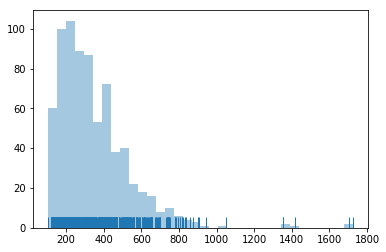

In [15]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

#
# Preproses Text, Convert Documents to Sequences, and One-Hot Encode Targets
#

# tokenize, build vocab and generate document sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(bunch.data)

sequences = tokenizer.texts_to_sequences(bunch.data)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

y_ohe = keras.utils.to_categorical(bunch.target)

#
# display dataset info
#

print(get_dataset_info_string(bunch))
print("Vocabulary Size:\t" + str(VOCAB_SIZE))

#
# padding and clipping documents for reccurent network input
#

print("\nPad and limit inputs to RNN... \n")

# pad and clip
MAX_ART_LEN = 500
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

# display document lengths and stats
document_lengths = np.array([len(d) for d in sequences])
MAX_DOCUEMNT_LENGTH, mean_length, std_length = max(document_lengths), np.mean(document_lengths), np.std(document_lengths)

print("Maximum Document Length: %s (words)" % MAX_DOCUEMNT_LENGTH)
print("Mean Document Length: %s (words)" % mean_length)
print("STD Document Lengths: %s " % std_length)
sns.distplot(list(document_lengths), kde=False, rug=True);

# MAX_ART_LEN parameter effects
docs_covered = document_lengths[ np.where( document_lengths <= MAX_ART_LEN ) ]
percent_docs_covered = len(docs_covered)/len(document_lengths)
stds_covered = (MAX_ART_LEN - mean_length)/std_length

print("\nMaximum Document Length Allowed: %s (words)" % MAX_ART_LEN)
print("Chosen Document Length Parameter Effects...\n")
print("Percentage of Documents Within Limit: %s" % (percent_docs_covered*100))
print("STD's Covered: %s" % stds_covered)

# display final specs
print("\nEncoded Dataset Dimensions:\n")
print('Shape of Data Tensor:', X.shape)
print('Shape of Label Tensor:', y_ohe.shape)


In [4]:
#
# Seperate Train and Test Data
#

from sklearn.model_selection import train_test_split

TEST_2_SET_RATIO = 0.2
DOUGLAS_ADAMS = 42
NUM_CLASSES = len(bunch.target_names)

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=TEST_2_SET_RATIO,
                                                            stratify=bunch.target, 
                                                            random_state=DOUGLAS_ADAMS)
#
# display dataset train / test split info
#

print(get_dataset_info_string(bunch))

print("\nEncoded Dataset Dimensions:\n")
print('Shape of Data Tensor:', X.shape)
print('Shape of Label Tensor:', y_ohe.shape)

print("\nTrain Test Split: ", TEST_2_SET_RATIO)

print("\nTrain Dataset Dimensions:\n")
print('Shape of Data Tensor:', X_train.shape)
print('Shape of Label Tensor:', y_train_ohe.shape)

print("\nTest Dataset Dimensions:\n")
print('Shape of Data Tensor:', X_test.shape)
print('Shape of Label Tensor:', y_test_ohe.shape)

Dataset Description: 
bbcsport
-----------------------------
Target|Target Name|Documents
-----------------------------
     0|athletics  |      101
     1|cricket    |      124
     2|football   |      265
     3|rugby      |      147
     4|tennis     |      100
-----------------------------
Total Documents:	737

Encoded Dataset Dimensions:

Shape of Data Tensor: (737, 500)
Shape of Label Tensor: (737, 5)

Train Test Split:  0.2

Train Dataset Dimensions:

Shape of Data Tensor: (589, 500)
Shape of Label Tensor: (589, 5)

Test Dataset Dimensions:

Shape of Data Tensor: (148, 500)
Shape of Label Tensor: (148, 5)


In [9]:
import os
import json

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

DATA_SETS_PATH = 'data/data_sets'

#
# Save and load word index
#

def save_word_index(word_index_file, word_index):
    with open(word_index_file, "w") as json_file:
        #json_file.write(word_index)
        json.dump(word_index, json_file)

        
def load_word_index(word_index_file):
    json_file = open(word_index_file, 'r')
    json_string = json_file.read()
    json_file.close()
    #json_string = u'{ "id":"123456789", ... }'
    word_index = json.loads(json_string)  
    return word_index 
    
#
# Preproses Text, One-Hot Encode Targets, Return Word Index
#

# format data for rnn input and word index
def format_data(bunch, max_article_len):

    # tokenize, build vocab and generate document sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(bunch.data)
    sequences = tokenizer.texts_to_sequences(bunch.data)

    # pad and clip
    X = pad_sequences(sequences, maxlen=max_article_len)
    y_ohe = keras.utils.to_categorical(bunch.target)
    word_index = tokenizer.word_index
    
    return X, y_ohe, word_index

#
# Import Dataset
#

def load_dataset(dataset_name, categories=None):
    
    global DATA_SETS_PATH
    
    container_path = os.path.join(DATA_SETS_PATH, dataset_name)
    bunch = load_files(container_path=container_path, description=DATA_SET_NAME, \
                       categories=categories, decode_error='ignore', encoding='utf-8')
    
    return bunch

#
# Format RNN input and Seperate Train and Test Data (and return word index)
# 

def ready_input(bunch, max_article_len, word_index_file, test_ratio=0.2, random_seed=42):
    
    # Format Data
    X, y_ohe, word_index = format_data(bunch, max_article_len)
    
    # save word_index file
    save_word_index(word_index_file, word_index)

    # Split it into train / test subsets
    X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=test_ratio,
                                                                stratify=bunch.target, 
                                                                random_state=random_seed)
    return X_train, X_test, y_train_ohe, y_test_ohe


In [10]:
#
# create glove embedding matrix from gloves pretrained models
#

def format_glove_embedding_matrix(dimensions, word_index):
    """ 
        returns embedding_matrix corresponding to word_index columns
        
        embdedding_index 
            format: {key : word, value : word vector}
            
        Note: unfound words in word_index will be zero vectors
    """
    
    # the embedding dimensions should match the file you load glove from
    assert dimensions in [50, 100, 200, 300]
    
    GLOVE_EMBEDDINGS_FILE_TEMPLATE = 'data/glove/glove.6B.%sd.txt'
    glove_file = GLOVE_EMBEDDINGS_FILE_TEMPLATE % dimensions
    
    #
    # create embeddings index
    #
    
    # format: {key : word, value : word vector} 
    embeddings_index = {}
    
    # load glove embeddings file and fill index
    f = open(glove_file)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #
    # build embedding matrix coressponding to given word_index
    #    Note: words not found in embedding index will be all-zeros.
    
    embedding_matrix = np.zeros((len(word_index) + 1, dimensions))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # return index and matrix
    return embedding_matrix
    

In [56]:
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN, Embedding
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import make_scorer, accuracy_score

from matplotlib import pyplot

#
# helper methods
#

def score_model(x, y, model, name, batch_size):
    score = model.evaluate(x, y,
                       batch_size=batch_size, verbose=1)

    for i,metric in enumerate(model.metrics_names):
        print("%s %s: %.2f%%" % (name, metric, score[i]))
        
def plot_training_history(history):
    # [TODO]: make not shitty
    #print(history.history.keys())

    pyplot.plot(history.history['acc'], label='accuracy')
    pyplot.plot(history.history['loss'], label='categorical_crossentropy')

    pyplot.legend()
    pyplot.show()
    
#
#  Save and load model_parameters
#
MODEL_PARAM_FILE_TEMPLATE = '%s/%s_parameters.json'

def save_model_parameters(model_id, model_parameters, model_dir):
    
    global MODEL_PARAM_FILE_TEMPLATE
    model_params_file = MODEL_PARAM_FILE_TEMPLATE % (model_dir, model_id)
    
    model_json = {
        'model_id' : model_id,
        'build_params' : model_parameters
    }
    
    with open(model_params_file, "w") as f:
        f.write(json.dumps(model_json))

        
def load_model_parameters(model_id, model_dir):
    
    global MODEL_PARAM_FILE_TEMPLATE
    model_params_file = MODEL_PARAM_FILE_TEMPLATE % (model_dir, model_id)
    
    json_file = open(model_params_file, 'r')
    model_json = json_file.read()
    json_file.close()
    return model_json    


#
# Build Simple RNN Model
#

def build_simple_RNN_model(word_index_file=None, max_article_length=None, n_classes=None, \
                    RNN_type='GRU', embed_size=50, state_size=100, dropout=0.2, \
                    recurrent_dropout=0.2, activation='sigmoid', loss='categorical_crossentropy', \
                    optimizer='rmsprop', metrics=['accuracy'] ):

    assert RNN_type in ['LSTM', 'GRU']
    
    # load word_index file
    word_index = load_word_index(word_index_file)

    # load pre-trained glove embeddings matrix
    embedding_matrix = format_glove_embedding_matrix(embed_size, word_index)
    
    #
    # create rnn
    #
    
    embedding_layer = Embedding(len(word_index) + 1, embed_size,
                                weights=[embedding_matrix], input_length=max_article_length,
                                trainable=False)
    rnn = Sequential()
    rnn.add(embedding_layer)
    if RNN_type == 'LSTM':
        rnn.add(LSTM(embed_size, dropout=dropout, recurrent_dropout=recurrent_dropout ))
    else:
        rnn.add(GRU(embed_size, dropout=dropout, recurrent_dropout=recurrent_dropout ))
    rnn.add(Dense(n_classes, activation=activation))
    rnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return rnn

#
# Train Model
#

def train_model(model, model_id, model_dir, X_train, y_train_ohe, X_test, y_test_ohe, epochs=100, batch_size=10, verbosity=1, patience=None):

    mc_file_template = '%s/%s-{epoch:03d}.h5' % (model_dir, model_id)
    checkpoint = keras.callbacks.ModelCheckpoint(mc_file_template, monitor='val_loss', \
                                                 verbose=verbosity, save_best_only=True, \
                                                 save_weights_only=False, mode='auto', \
                                                 period=1)
    callbacks = [checkpoint]
    if patience is not None:
        callbacks += [EarlyStopping(monitor='val_loss', patience=patience)]

    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_ohe),
               callbacks=callbacks, verbose=verbosity )
    
    return history


In [59]:
import itertools

#
# hyper parameter tuning
#

WORD_INDEX_FILENAME_TEMPLATE = '%s/word_index.json'

# grid search
def tune_hyper_parameters(dataset_name, model_files_dir, max_article_length, categories=None, \
                          test_ratio=0.2, random_seed=42, verbosity=1, epochs=10, batch_size=64):

    word_index_file = WORD_INDEX_FILENAME_TEMPLATE % model_files_dir
    
    #
    # Import Dataset and format for testing and training
    #
    
    bunch = load_dataset(DATA_SET_NAME, CATEGORIES)
    X_train, X_test, y_train_ohe, y_test_ohe = ready_input(bunch, max_article_length, \
                                                                       word_index_file, \
                                                                       test_ratio=test_ratio, \
                                                                       random_seed=random_seed)

    #
    # fixed parameters
    #
    word_index_file = word_index_file
    n_classes = len(bunch.target_names) # num_classes
    
    train_params = {
        'model' : None, # dynamically set
        'model_id' : None, # dynamically set
        'model_dir' : model_files_dir,
        'X_train' : X_train,
        'X_test' : X_test,
        'y_train_ohe' : y_train_ohe,
        'y_test_ohe' : y_test_ohe,
        'epochs' : epochs,
        'batch_size' : batch_size, 
        'verbosity' : verbosity
    }

    #
    # grid -- tunable params
    #
    
    rnn_types = ['GRU', 'LSTM']
    embed_sizes = [50] # [50, 100, 200, 300] # [TODO]: make dynamic
    state_sizes = [15*i for i in range(5)]
    dropouts = list(np.linspace(0, 0.5, num=2))
    recurrent_dropouts = list(np.linspace(0, 0.5, num=2))
    dense_activations = ['sigmoid']
    optimizers = ['rmsprop']

    build_param_ids = ['RNN_type','embed_size' ,'state_size', 'dropout', 'recurrent_dropout', 'activation', 'optimizer']
    build_params_set = [rnn_types, embed_sizes, state_sizes, dropouts, recurrent_dropouts, dense_activations, optimizers]

    build_param_permutes = itertools.product(*build_params_set)
    for i, build_param_values in enumerate(build_param_permutes):
        
        # set dynamic build parameters
        build_params = dict(zip(build_param_ids, build_param_values))
        
        # add fixed build params
        build_params['word_index_file'] = word_index_file
        build_params['n_classes'] = n_classes
        build_params['max_article_length'] = max_article_length
    
        # generate model_id 
        model_id = i
        
        # save model parameters
        save_model_parameters(model_id, build_params, model_files_dir)
        
        # build
        model = build_simple_RNN_model(**build_params)

        # display summary
        print(model.summary())
        
        # add model_id and model to train parameters
        train_params['model'] = model
        train_params['model_id'] = model_id
    
        # train
        history = train_model(**train_params)

        # display scores
        #plot_training_history(history)
        #score_model(X_train, y_train_ohe, model, "FINAL train", batch_size)
        #score_model(X_test, y_test_ohe, model, "FINAL test", batch_size)

    
 

In [60]:
#
# Settings
#

DATA_SET_NAME = 'bbcsport'
CATEGORIES = ['athletics', 'cricket', 'football', 'rugby', 'tennis']
MAX_ART_LEN = 500
TEST_2_SET_RATIO = 0.2
RANDOM_SEED = 42
MODEL_FILES_DIR = 'data/model_files'
VERBOSITY = 2
EPOCHS = 100
BATCH_SIZE = 250

# grid search for best parameters
tune_hyper_parameters(DATA_SET_NAME, MODEL_FILES_DIR, MAX_ART_LEN, categories=CATEGORIES, \
                     test_ratio=TEST_2_SET_RATIO, random_seed=RANDOM_SEED, verbosity=VERBOSITY, epochs=EPOCHS, batch_size=BATCH_SIZE)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 50)           711250    
_________________________________________________________________
gru_9 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 255       
Total params: 726,655
Trainable params: 15,405
Non-trainable params: 711,250
_________________________________________________________________
None
Train on 589 samples, validate on 148 samples
Epoch 1/100
 - 2s - loss: 1.5531 - acc: 0.3616 - val_loss: 1.5069 - val_acc: 0.3784

Epoch 00001: val_loss improved from inf to 1.50686, saving model to data/model_files/0-001.h5
Epoch 2/100
 - 1s - loss: 1.5016 - acc: 0.3939 - val_loss: 1.4789 - val_acc: 0.3851

Epoch 00002: val_loss improved from 1.50686 to 1.47890, saving model to data/mod

KeyboardInterrupt: 